In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/BienSoXe/Bien_so_xe_full.zip", 'r') as zipObj:
    zipObj.extractall()

In [3]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

f=open("/content/GreenParking/location.txt", 'r')
file_path="/content/GreenParking/"
j=0
x=np.zeros((1747, 303, 472, 3), dtype=np.uint8)
y=np.zeros((1747, 4))
for i, line in enumerate(f):
    if (i==1424):
        continue
    url, c, ix, iy, iw, ih=line.split()
    ix,iy,iw,ih=int(ix), int(iy), int(iw), int(ih)
    img=cv2.imread(file_path+url)
    x[j]=img
    y[j]=[ix,iy,iw,ih]
    j+=1
    if (i%100==0 and i!=0):
        print("Load "+str(i)+" image complete!")

Load 100 image complete!
Load 200 image complete!
Load 300 image complete!
Load 400 image complete!
Load 500 image complete!
Load 600 image complete!
Load 700 image complete!
Load 800 image complete!
Load 900 image complete!
Load 1000 image complete!
Load 1100 image complete!
Load 1200 image complete!
Load 1300 image complete!
Load 1400 image complete!
Load 1500 image complete!
Load 1600 image complete!
Load 1700 image complete!


In [4]:
print(x.shape)
print(y.shape)

(1747, 303, 472, 3)
(1747, 4)


In [5]:
backgrounds=np.load("/content/drive/My Drive/BienSoXe/backgrounds.npy")

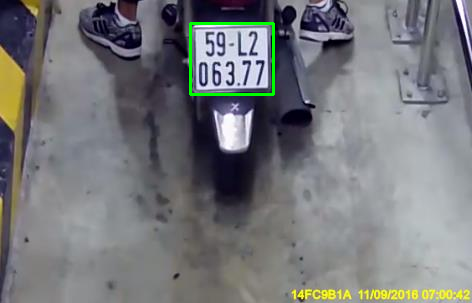

In [6]:
import copy
img=copy.copy(x[2])
[ix,iy,iw,ih]=y[2]
cv2.rectangle(img, (int(ix), int(iy)), (int(ix+iw), int(iy+ih)), (0,255,0), 2)
cv2_imshow(img)

In [53]:
def change_background(x, y):
    mask=np.zeros((303,472,1))
    mask[int(y[1]):int(y[1]+y[3]), int(y[0]):int(y[0]+y[2]), :]=1
    for j in range(0, 5):
        mask=np.expand_dims(cv2.blur(mask,(5,5)), axis=-1)*mask
    background=backgrounds[np.random.randint(backgrounds.shape[0])]
    return x*mask+cv2.resize(background, (472, 303))*(1-mask)

In [8]:
def flip(x, y):
    if (np.random.randint(2)==1):
        x=cv2.flip(x,1)
        y=[x.shape[1]-y[0]-y[2], y[1], y[2], y[3]]
    return x,y

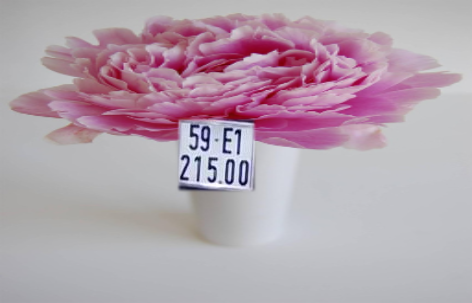

In [58]:
img=copy.copy(x[1])
[ix,iy,iw,ih]=y[1]
img=change_background(img, [ix,iy,iw,ih])
#cv2.rectangle(img, (int(ix), int(iy)), (int(ix+iw), int(iy+ih)), (0,255,0), 2)
cv2_imshow(img)

In [10]:
def trans(x, y):
    x_trans=np.random.randint(int(-y[0]+1), int(x.shape[1]-y[0]-y[2]-1))
    y_trans=np.random.randint(int(-y[1]+1), int(x.shape[0]-y[1]-y[3]-1))
    M=np.float32([[1,0,x_trans],[0,1,y_trans]])
    x=cv2.warpAffine(x, M, (x.shape[1], x.shape[0]))
    y=[y[0]+x_trans, y[1]+y_trans, y[2], y[3]]
    return x, y

In [13]:
import math
def rotate(x, y):
    alpha_do=np.random.randint(-15, 15)
    alpha=alpha_do*math.pi/180
    center=(y[0]+y[2]//2, y[1]+y[3]//2)
    M=cv2.getRotationMatrix2D(center, alpha_do, 1) 
    rotated=cv2.warpAffine(x, M, (x.shape[1], x.shape[0]))
    wh_bienSo=(y[3]*math.sin(abs(alpha))+y[2]*math.cos(abs(alpha)), y[3]*math.cos(abs(alpha))+y[2]*math.sin(abs(alpha)))
    x_bienSo=center[0]-wh_bienSo[0]//2
    y_bienSo=center[1]-wh_bienSo[1]//2
    if (x_bienSo<=0 or y_bienSo<=0 or (x_bienSo+wh_bienSo[0])>=x.shape[1] or (y_bienSo+wh_bienSo[1])>=x.shape[0]):
        return x, y
    y=[x_bienSo, y_bienSo, wh_bienSo[0], wh_bienSo[1]]
    return rotated, y

In [23]:
def crop(x, y):
    x0_crop=np.random.randint(y[0])
    y0_crop=np.random.randint(y[1])
    x1_crop=np.random.randint(y[0]+y[2], x.shape[1])
    y1_crop=np.random.randint(y[1]+y[3], x.shape[0])
    x_crop=x[y0_crop:y1_crop, x0_crop:x1_crop]
    y=[y[0]-x0_crop, y[1]-y0_crop, y[2], y[3]]
    x=cv2.resize(x_crop, (x.shape[1], x.shape[0]))
    y=[int(y[0]*x.shape[1]/(x1_crop-x0_crop)), int(y[1]*x.shape[0]/(y1_crop-y0_crop)),
       int(y[2]*x.shape[1]/(x1_crop-x0_crop)), int(y[3]*x.shape[0]/(y1_crop-y0_crop))]
    return x, y

In [27]:
def brightness(x, y):
    value=np.random.randint(-80, 80)
    x=cv2.cvtColor(x.astype(np.float32), cv2.COLOR_BGR2HSV)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            temp=x[i,j,2]+value
            if (temp>255): x[i,j,2]=255
            elif (temp<0): x[i,j,2]=0
            else: x[i,j,2]=temp
    x=cv2.cvtColor(x, cv2.COLOR_HSV2BGR)
    return x, y

In [13]:
def augmentation(x, y):
    print("Augmentation: ", end=' ')
    for i in range(x.shape[0]):
        if (i%100==0 and i!=0): print(i, end=' ')
        x[i],y[i]=flip(x[i],y[i])
        x[i],y[i]=trans(x[i],y[i])
        x[i]=change_background(x[i],y[i])
        x[i],y[i]=rotate(x[i],y[i])
        x[i],y[i]=crop(x[i],y[i])
        x[i],y[i]=brightness(x[i],y[i])
    print("")
    return x,y

In [14]:
x_aug, y_aug=augmentation(copy.copy(x[1500:]),copy.copy(y[1500:]))
for i in range(4):
    x_aug_1, y_aug_1=augmentation(copy.copy(x[1500:]),copy.copy(y[1500:]))
    x_aug=np.concatenate((x_aug,x_aug_1), axis=0)
    y_aug=np.concatenate((y_aug,y_aug_1), axis=0)
print(x_aug.shape)
print(y_aug.shape)

Augmentation:  100 200 
Augmentation:  100 200 
Augmentation:  100 200 
Augmentation:  100 200 
Augmentation:  100 200 
(1235, 303, 472, 3)
(1235, 4)


In [15]:
x_aug=np.concatenate((x_aug, x[1500:]), axis=0)
y_aug=np.concatenate((y_aug, y[1500:]), axis=0)

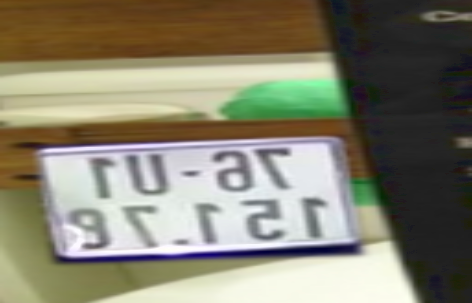

In [16]:
cv2_imshow(x_aug[4])

In [17]:
# np.save("/content/drive/My Drive/BienSoXe/x_test.npy", x_aug)
# np.save("/content/drive/My Drive/BienSoXe/y_test.npy", y_aug)